In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
%matplotlib notebook
db_connect_params = {
    "host" : "194.87.210.189",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt5"
}

In [3]:
import time
import cProfile, pstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from data_providers import DbDataProviderRT5
from data_providers import ClickHouseConnector

from core.context import BasicContext
from data_point import DataPoint, DataPointFactory
from core.action_controller import ActionControllerDiffReward

from core.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from core.observation_builder.features import OrderbookDiffFeature2D as OrderbookDiffFeature2D_old
from core.observation_builder.features2 import OrderbookDiffFeature2D

## DatasetDownload

In [5]:
path_train = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-train.csv"
path_test = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test.csv"
path_test2 = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test2.csv"

data_train = pd.read_csv(path_train, index_col='ts')
data_test = pd.read_csv(path_test, index_col='ts')
data_test2 = pd.read_csv(path_test2, index_col='ts')

In [6]:
try:
    dataset = pd.read_csv("./test_dataset.csv", index_col='ts')
    print("Прочитано из файла")
except FileNotFoundError:
    
    ts = int(time.time())
    period = 60
    total_points = 5000

    pair = "BTC_USDT"


    #----
    with ClickHouseConnector(db_connect_params) as conn:
        data_provider = DbDataProviderRT5(conn)

        dataset = data_provider.get(
                                ts,
                                period,
                                total_points,
                                pair
                            )
    dataset.to_csv("./test_dataset.csv")
    print("Загружен новый датасет")
    
print(dataset.shape)

Прочитано из файла
(5000, 11)


In [53]:
levels=(0.001, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02)
#levels=(0.01, )

precompute = PrecomputeOrderbookDiffFeature()
for level in levels:
    data_train = precompute.process(data_train, level)
    data_test = precompute.process(data_test, level)
    data_test2 = precompute.process(data_test2, level)

In [54]:
dataset = data_train

In [55]:
dataset.head()

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,asks_0.005,bids_0.005,asks_0.0075,bids_0.0075,asks_0.01,bids_0.01,asks_0.015,bids_0.015,asks_0.02,bids_0.02
ts,,,,,,,,,,,,,,,,,,,,,
1662185340,2022-09-03 06:09:00,19929.31,19928.361,"{'19929.31': 0.5, '19931.24': 0.25, '19932.14'...","{'19928.36': 0.25, '19926.23': 0.5, '19924.98'...",0.177276,0.164399,0.341675,9,10,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1662185640,2022-09-03 06:14:00,19915.01,19913.000,"{'19915.01': 0.492324, '19920.6': 0.25, '19922...","{'19913': 0.25, '19911.03': 0.226976, '19910.9...",0.018660,0.091484,0.110144,6,10,...,7.738039,7.320904,11.595287,12.124281,13.899554,12.174033,14.103179,20.459104,16.642084,22.933864
1662185940,2022-09-03 06:19:00,19910.93,19908.920,"{'19910.93': 0.467253, '19913.63': 0.25, '1991...","{'19908.92': 0.25, '19906.6': 0.25, '19903.85'...",0.108600,0.187092,0.295692,9,7,...,8.272923,5.512412,12.130171,10.357053,14.434438,12.323617,14.603758,19.650697,17.176968,21.125424
1662186240,2022-09-03 06:24:00,19836.08,19826.230,"{'19836.08': 0.5, '19838.07': 0.25, '19845.43'...","{'19826.23': 0.25, '19825.24': 0.14, '19825.23...",0.548822,0.795283,1.344105,16,11,...,10.705948,2.444171,10.707196,6.543322,13.011463,10.653983,13.168183,17.980985,15.753995,21.424037
1662186540,2022-09-03 06:29:00,19859.43,19858.441,"{'19859.43': 0.5, '19865.16': 0.25, '19867.4':...","{'19858.44': 0.25, '19857.44': 0.5, '19855.44'...",0.374214,0.659355,1.033569,8,13,...,7.816052,13.042751,11.682637,19.351135,11.723637,19.370423,14.029152,23.802509,14.232866,29.361107


<IPython.core.display.Javascript object>


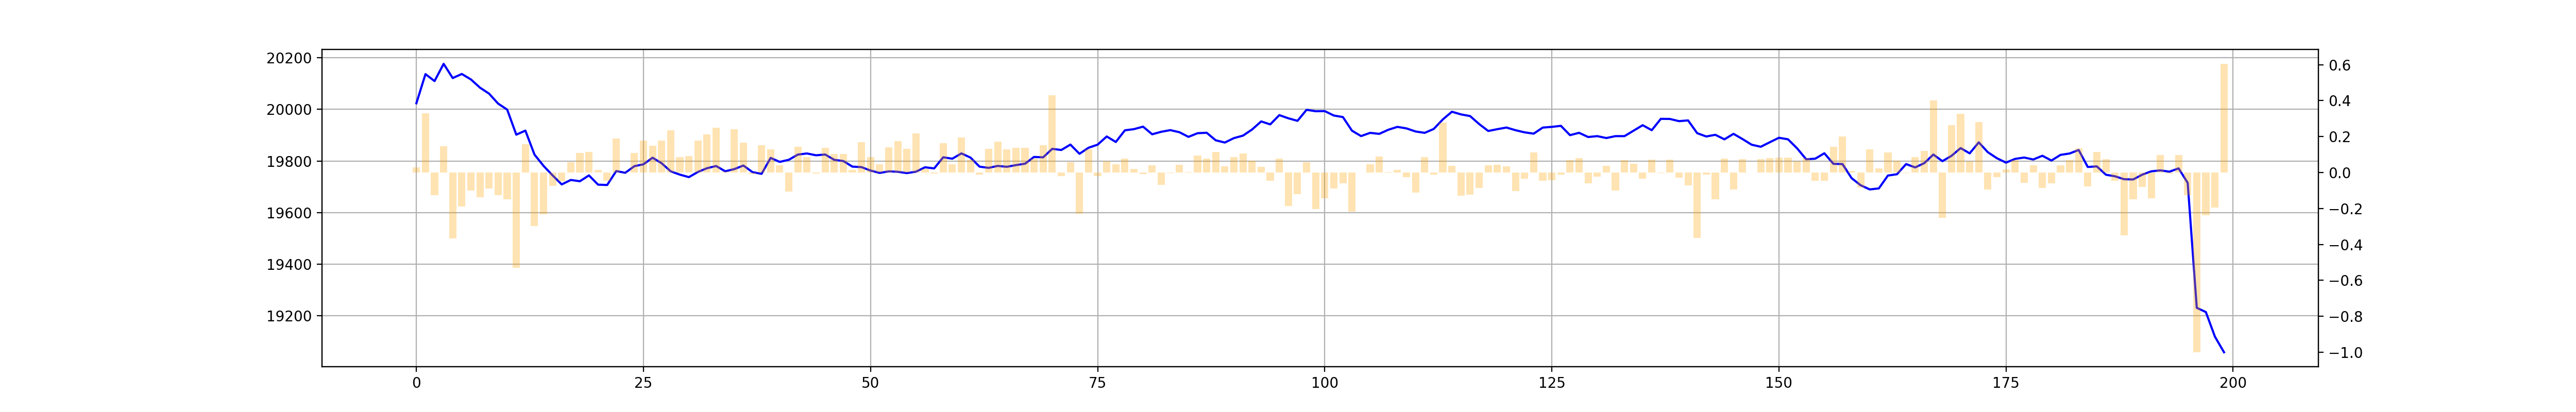

<BarContainer object of 200 artists>

In [168]:
bound_low = 800
bound_hi = 1000

level_id = 3


rates = dataset.loc[:, "highest_bid"].values[bound_low:bound_hi]
asks = dataset.loc[:, "asks_" + str(levels[level_id])].values[bound_low:bound_hi]
bids = dataset.loc[:, "bids_" + str(levels[level_id])].values[bound_low:bound_hi]
f1 = (bids - asks)/(bids + asks)
f1_diff = np.concatenate([np.zeros(1), np.diff(feature_bounded)])
x_values = np.array(range(len(f1)))





# -------------------------------
fig, ax = plt.subplots(figsize=(25,4), ncols=1, nrows=1)
ax2 = ax.twinx()

ax.plot(rates, color='blue')
#ax2.plot(feature_bounded, color='red', alpha=0.3)
#ax2.plot(asks_bounded, color='orange', alpha=0.3)
#ax2.plot(bids_bounded, color='purple', alpha=0.3)

ax.grid()


#ax.bar(x=x_values, height=rates_d_bounded, color='blue', alpha=0.6)
ax2.bar(x=x_values, height=f1, color='orange', alpha=0.3)


In [171]:
df = pd.DataFrame([0,1,2,3,4,5,6,7,8,9,10,11,12], columns=["feat"])
df.head()

,feat
0,0
1,1
2,2
3,3
4,4


,feat
12,12
11,11
10,10
9,9
8,8
7,7
6,6
5,5
4,4
3,3


In [235]:
# .sort_index(ascending=False)
df.sort_index(ascending=False).rolling(4, closed='left',center=False).mean().sort_index(ascending=True)


,feat
0,2.5
1,3.5
2,4.5
3,5.5
4,6.5
5,7.5
6,8.5
7,9.5
8,10.5
9,NaN


In [239]:
dataset["highest_bid"].sort_index(ascending=False).rolling(4,  closed='left',center=False).mean().sort_index(ascending=True)

ts
1662185340    19876.64775
1662185640    19870.45525
1662185940    19862.36275
1662186240    19873.30000
1662186540    19883.23975
                 ...     
1662680340    19314.98275
1662680640            NaN
1662680940            NaN
1662681240            NaN
1662681540            NaN
Name: highest_bid, Length: 1655, dtype: float64

In [144]:
level_id = 3
offset = 2

for level in levels:

    rates = dataset.loc[:, "highest_bid"].values
    asks = dataset.loc[:, "asks_"+ str(level)].values
    bids = dataset.loc[:, "bids_"+ str(level)].values
    feature = - asks + bids

    current = feature [:-offset]
    future = rates[offset:]

    r = np.corrcoef(current, future)
    print(f"Уровень {level:>9}: коэффициент корреляции {r[0][1]:.3f}")

Уровень     0.001: коэффициент корреляции 0.030
Уровень    0.0025: коэффициент корреляции 0.057
Уровень     0.005: коэффициент корреляции 0.091
Уровень    0.0075: коэффициент корреляции 0.131
Уровень      0.01: коэффициент корреляции 0.174
Уровень     0.015: коэффициент корреляции 0.142
Уровень      0.02: коэффициент корреляции 0.082


Коэффициент корреляции 0.011


<IPython.core.display.Javascript object>


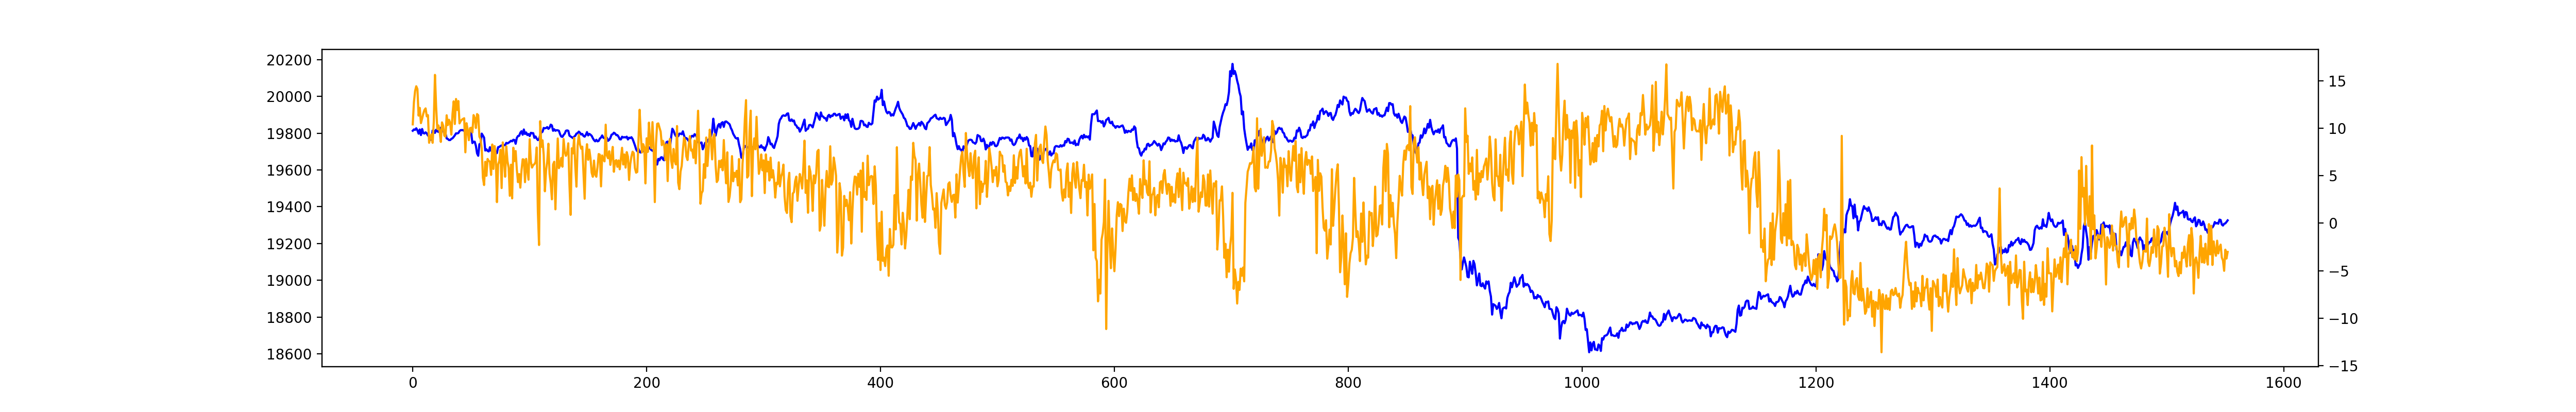

In [143]:
level_id = 2

bound_low = 100
bound_hi = 2000

rates_bounded = dataset.loc[:, "highest_bid"].values[bound_low:bound_hi]
feature_bounded = feature[bound_low:bound_hi]

current = feature_bounded[:-offset]
future = rates_bounded[offset:]

x_values = np.array(range(len(current)))

# -------------------------------
r = np.corrcoef(current, future)
print(f"Коэффициент корреляции {r[0][1]:.3f}")

# -------------------------------
fig, ax = plt.subplots(figsize=(25,4), ncols=1, nrows=1)
ax2 = ax.twinx()

ax.plot(future, color='blue')
ax2.plot(current, color='orange')

#ax.bar(x=x_values, height=rates_d_bounded, color='blue', alpha=0.6)
#ax2.bar(x=x_values, height=future, color='orange', alpha=0.3)


In [33]:
test = rates_bounded[1:8]
print(test)

[19913.    19908.92  19826.23  19858.441 19888.23  19876.55  19869.979]


In [34]:
test[1:]

array([19908.92 , 19826.23 , 19858.441, 19888.23 , 19876.55 , 19869.979])

In [35]:
test[:-1]

array([19913.   , 19908.92 , 19826.23 , 19858.441, 19888.23 , 19876.55 ])

Коэффициент корреляции 0.243


In [13]:
rates_bounded

array([], dtype=float64)

# Context

In [13]:
dpf = DataPointFactory(dataset, step_size=1, offset=50, observation_len=10, future_points=0)

context = BasicContext()
action_controller = ActionControllerDiffReward(context)
dp = dpf.get_current_step()
context.update_datapoint(dp)

# Класс фичи

In [14]:
"""
Orderbook features

"""
import logging
import numpy as np

from core.observation_builder.features2.abstract_feature import AbstractFeature

logger = logging.getLogger(__name__)


class OrderbookDiffFeature2D(AbstractFeature):
    def __init__(self, context, step_factor=(1,), scale_output=0.3, levels=(0.001, 0.0025, 0.005, 0.0075)):
        super().__init__(context, step_factor=step_factor, scale_output=scale_output)
        self.levels = levels

    def _get(self):
        data_point = self.context.data_point
        obs = []

        for sf in self.step_factor:

            for level in self.levels:
                asks = data_point.get_values("asks_" + str(level), step_factor=sf)
                bids = data_point.get_values("bids_" + str(level), step_factor=sf)

                feature = bids - asks
                if sf > 1:
                    res = []
                    for i in range(data_point.observation_len):
                        val = feature[sf * i: sf * (i + 1)]
                        res.append(val.sum())
                    feature = np.array(res)
                
                feature = feature / np.abs(feature).mean() * self.scale_output
                feature = feature.reshape(-1, 1)    

                obs.append(feature)

        feature = np.concatenate([*obs], axis=1)

        return feature

# Perfomance test

In [15]:
def perfomance_test(dataset):
    dpf = DataPointFactory(dataset, step_size=1, offset=150, observation_len=30, future_points=0)
    dp = dpf.reset()
    done = False
    scale_factor = (1,2)
    
    feature = OrderbookDiffFeature2D(context, step_factor=scale_factor, levels=(0.001,), scale_output=1)

    while not done:
        dp, done = dpf.get_next_step()
        obs = feature.get()
        
#cProfile.run("perfomance_test(dataset)")

In [19]:
profiler = cProfile.Profile()
profiler.enable()

perfomance_test(data_test2)

profiler.disable()

In [21]:
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

         3109035 function calls (3092065 primitive calls) in 1.984 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4241    0.161    0.000    1.372    0.000 /Users/alex/Dev_projects/MyOwnRepo/rt_libs/src/core/observation_builder/features2/orderbook.py:20(_get)
    55133    0.127    0.000    0.127    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   593796    0.093    0.000    0.117    0.000 {built-in method builtins.isinstance}
    21207    0.093    0.000    0.559    0.000 /Users/alex/Dev_projects/venvs/env_rt_p39/lib/python3.9/site-packages/pandas/core/indexing.py:834(_getitem_lowerdim)
    21207    0.071    0.000    1.205    0.000 /Users/alex/Dev_projects/venvs/env_rt_p39/lib/python3.9/site-packages/pandas/core/indexing.py:954(__getitem__)
    84828    0.055    0.000    0.122    0.000 {built-in method builtins.any}
    16964    0.054    0.000    0.123    0.000 /Users/alex/Dev_projects/venvs/env_rt_p39/lib/python3.9/

# Оценка распределения

In [16]:
dataset = data_test2

done = False

dpf = DataPointFactory(dataset, step_size=1, offset=360, observation_len=30, future_points=0)
context = BasicContext()
step_factor = (1,3,12)
levels=(0.001, 0.0025, 0.005, 0.0075)
feature = OrderbookDiffFeature2D(context, step_factor=step_factor, levels=levels, scale_output=0.3)

results = {}

while not done:
    dp, done = dpf.get_next_step()
    context.update_datapoint(dp)
    
    obs = feature.get()
    
    for sf_id in range(len(step_factor)):
        key_sf = f"sf-{step_factor[sf_id]}"
        if key_sf not in results:
                results[key_sf] = {}
        
        for level_id in range(len(levels)):
            values = obs[:, sf_id+level_id]
            
            key_level = f"level-{levels[level_id]}"
            
            if key_level not in results[key_sf]:
                results[key_sf][key_level] = values
            else:
                results[key_sf][key_level] = np.concatenate([results[key_sf][key_level], values])
    
    

<IPython.core.display.Javascript object>


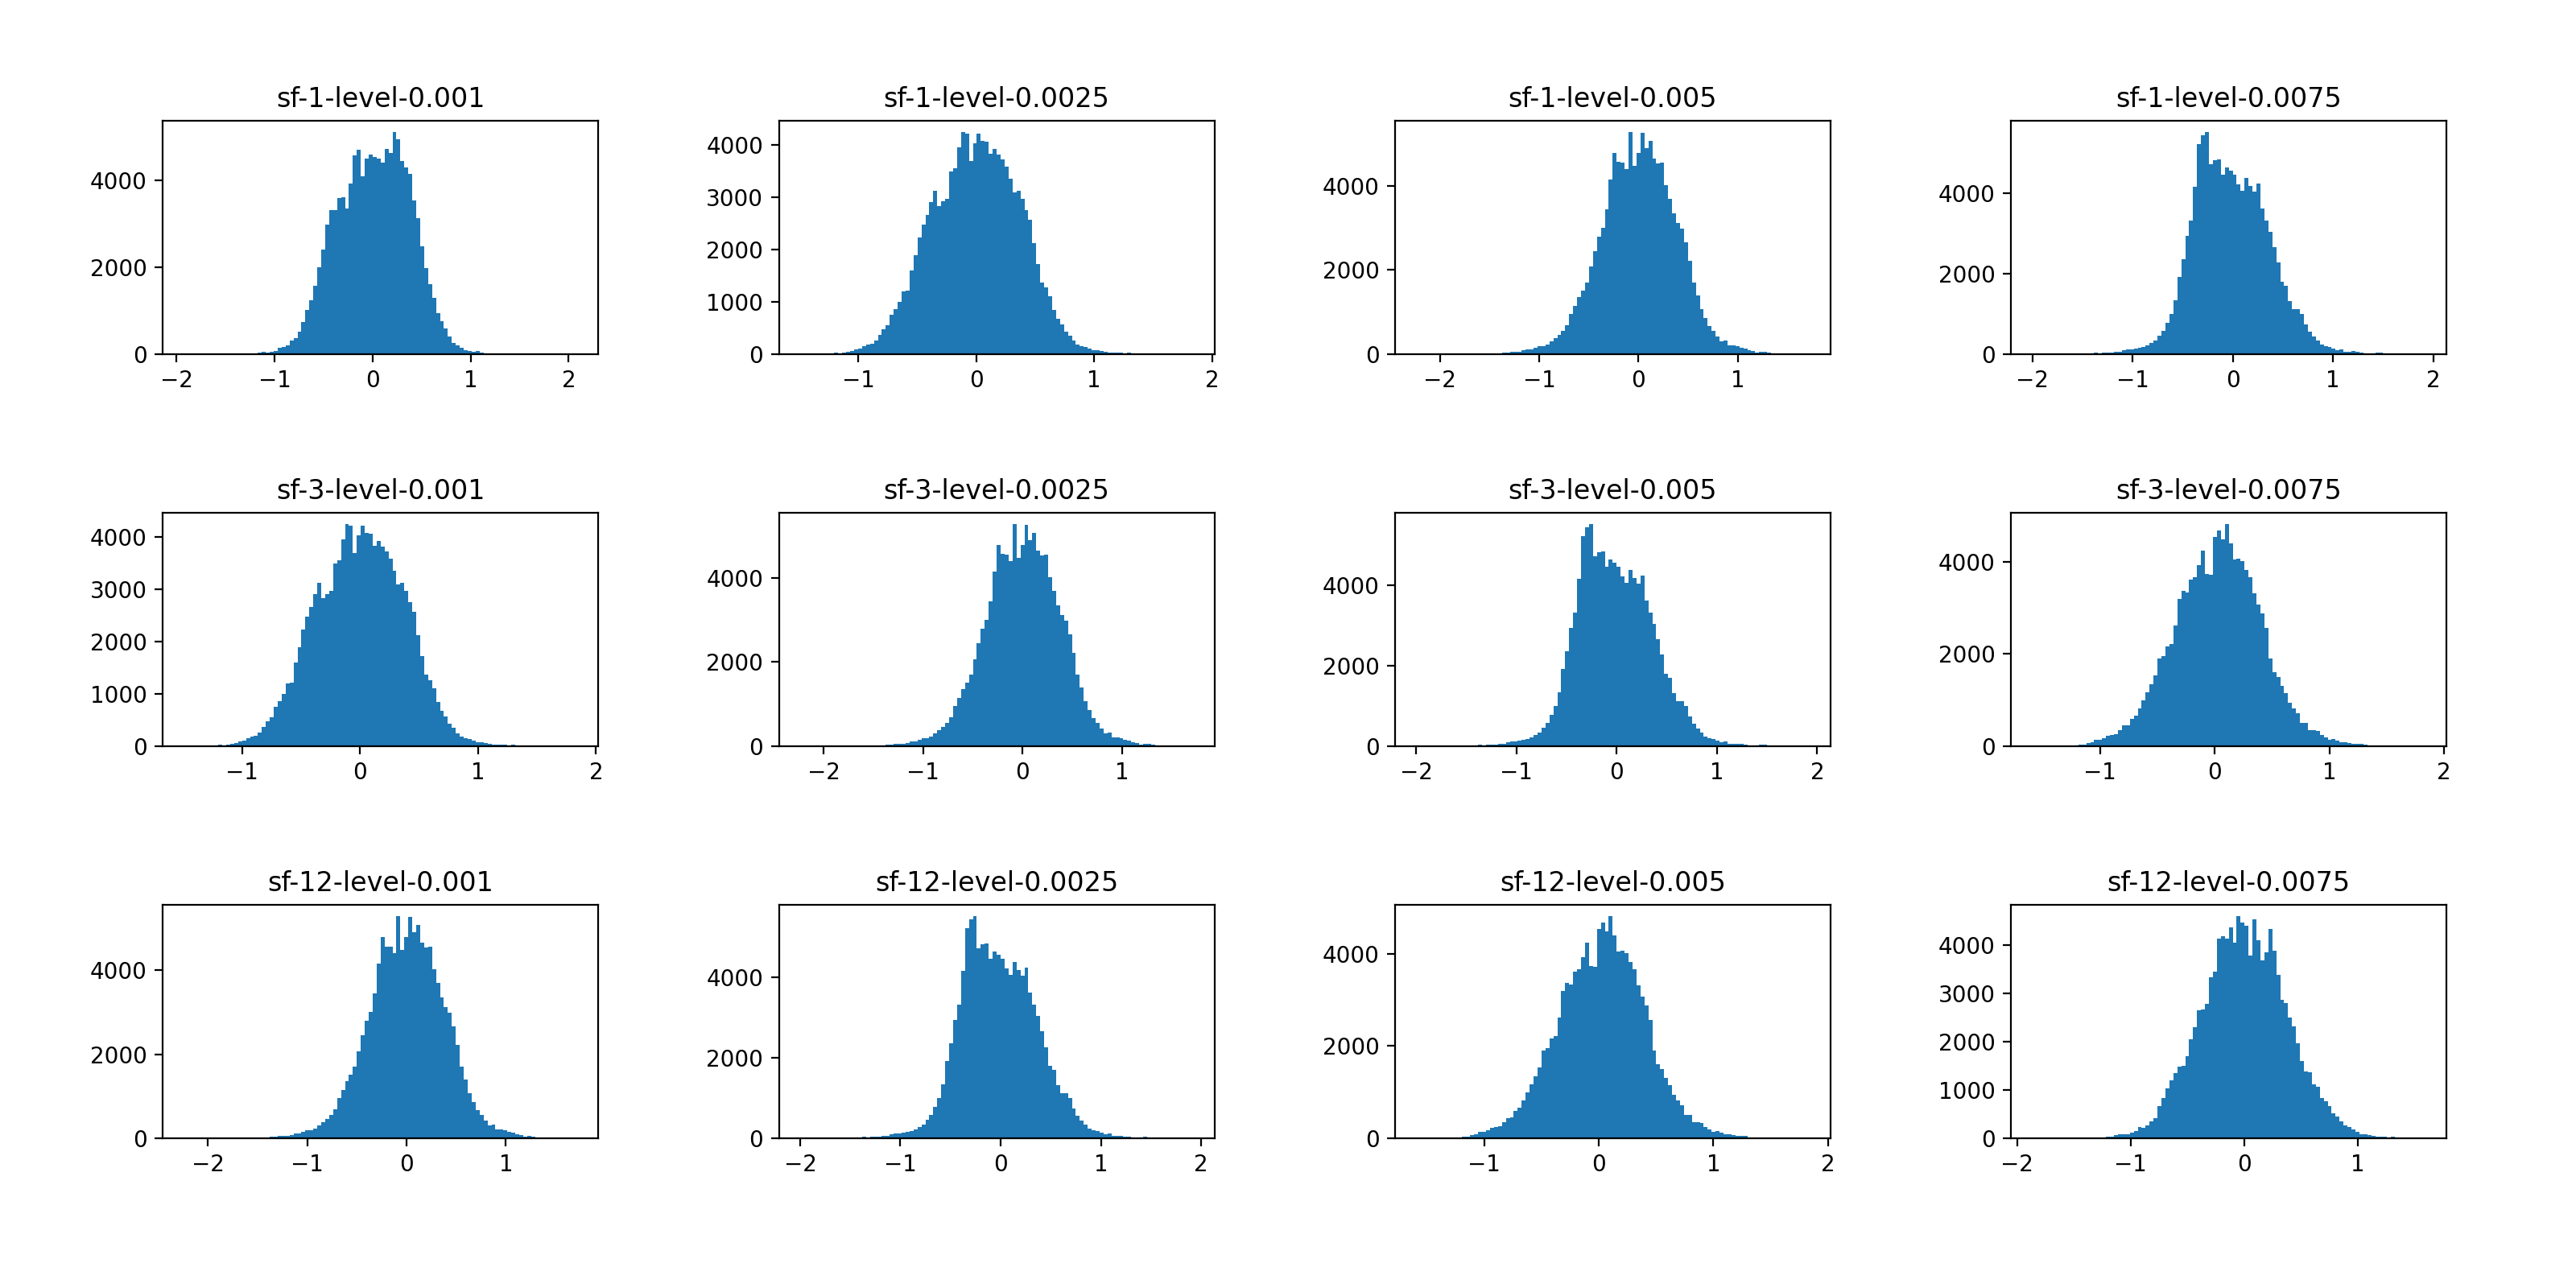

In [17]:
fig, ax = plt.subplots(figsize=(16,8), nrows=len(step_factor), ncols=len(levels))
fig.tight_layout(pad=5.0)
for sf_id in range(len(step_factor)):
    key_sf = f"sf-{step_factor[sf_id]}"
    for level_id in range(len(levels)):
        
        key_level = f"level-{levels[level_id]}"
        
        values = results[key_sf][key_level]
        
        ax[sf_id][level_id].hist(values, bins=100)
        ax[sf_id][level_id].title.set_text(f"{key_sf}-{key_level}")

# Корреляция с целевой переменной

In [29]:
dataset = data_test2

done = False

dpf = DataPointFactory(dataset, step_size=1, offset=360, observation_len=30, future_points=0)
context = BasicContext()
step_factor = (1,3,12)
levels=(0.001, 0.0025, 0.005, 0.0075)
feature = OrderbookDiffFeature2D(context, step_factor=step_factor, levels=levels, scale_output=0.3)




#step_factor = 1
level = 0.001
results = {}
rates = []

while not done:
    dp, done = dpf.get_next_step()
    context.update_datapoint(dp)
    
    obs = feature.get()
    
    highest_bid = dp.get_value("highest_bid")
    rates.append(highest_bid[0])
    
    for sf_id in range(len(step_factor)):
        key_sf = f"sf-{step_factor[sf_id]}"
        if key_sf not in results:
                results[key_sf] = {}
        
        for level_id in range(len(levels)):
            values = obs[:, sf_id+level_id]
            
            key_level = f"level-{levels[level_id]}"
            
            if key_level not in results[key_sf]:
                results[key_sf][key_level] = values
            else:
                results[key_sf][key_level] = np.concatenate([results[key_sf][key_level], values])
    
    

In [30]:
results.keys()

dict_keys(['sf-1', 'sf-3', 'sf-12'])

{'level-0.001': array([-0.12060926, -0.32517732,  0.33600474, ...,  0.57294829,
        -0.24537308, -0.57614201]),
 'level-0.0025': array([-0.08629411, -0.25814892,  0.32116321, ...,  0.69082564,
        -0.23989247, -0.50847834]),
 'level-0.005': array([-0.14304649, -0.11294908,  0.20511266, ...,  0.57534231,
        -0.2317915 , -0.35281005]),
 'level-0.0075': array([-0.14813882, -0.47372809,  0.20122397, ...,  0.22720163,
        -0.3265496 , -0.49716048])}

In [64]:
len(rates)

4031

In [65]:
sf = "sf-3"
level = "level-0.001"

bound_low = 0
bound_hi = 4000

rates_bounded = rates[bound_low:bound_hi]
rates_d_bounded = np.diff(rates)[bound_low:bound_hi]
feature_bounded = results[sf][level][bound_low:bound_hi]

x_values = np.array(range(len(rates_bounded)))

# -------------------------------
r = np.corrcoef(rates_bounded, feature_bounded)
print(f"Коэффициент корреляции {r[0][1]:.3f}")

# -------------------------------
#fig, ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
#ax2 = ax.twinx()

#ax.plot(rated_diff[low:hi])
#ax.plot(rates_d_bounded, color='blue')

#ax.bar(x=x_values, height=rates_d_bounded, color='blue', alpha=0.6)
#ax2.bar(x=x_values, height=feature_bounded, color='orange', alpha=0.3)


Коэффициент корреляции -0.041


Коэффициент корреляции -0.069


In [23]:
sf_id = 1

rated_diff = np.diff(rates[step_factor[sf_id]])    
rated_ = rates[step_factor[sf_id]]
values_plot = results[step_factor[sf_id]]
values_plot = values_plot[1:]

low = 0
hi = 100
                           
                           


IndexError: list index out of range

In [2]:
import numpy as np

In [3]:
r = np.corrcoef(rated_, values_plot)

NameError: name 'rated_' is not defined

# Тестирование

In [204]:
dp, done = dpf.get_next_step()
context.update_datapoint(dp)

In [215]:
feature = OrderbookDiffFeature2D(context, scale_factor=(1,4,5), levels=levels, scale_output=0.2)
obs = feature.get()
obs

array([[-0.05144111, -0.14833379, -0.26985304, -0.23555   , -0.38640493,
        -0.12150745, -0.9143708 , -1.19572537,  0.51820806, -0.55334874,
        -1.50321305, -1.3420266 ],
       [ 0.11758023, -0.0887567 , -0.18697687, -0.15963396, -0.6308805 ,
        -0.18287898, -1.01838164, -1.10332991, -0.91005301, -1.30792764,
        -1.52356679, -1.7093618 ],
       [-0.14460908, -0.08175442, -0.30454063, -0.25299657, -0.58560283,
        -0.65193838, -0.42574929, -0.57523906, -0.37659666, -0.05347372,
        -0.96153609, -1.2924345 ],
       [-0.40081951, -0.47071279, -0.31747136, -0.29459158, -0.51427487,
        -0.75037675, -0.41890078, -0.84606889, -1.2802637 , -0.77154988,
        -1.10652286, -1.04016914],
       [-0.09875145, -0.4088239 , -0.29558462, -0.27707776, -1.16795409,
        -0.69606301, -0.66979721, -0.64187513, -0.60109479, -0.88426777,
        -0.36142879, -0.75917855],
       [ 0.17357419, -0.12142251, -0.01754475, -0.0582365 , -1.3300575 ,
        -1.10122427, -

In [162]:
dp.data.tail(10)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num,asks_0.01,bids_0.01
ts,,,,,,,,,,,,,
1675193291,2023-01-31 22:28:11,23112.969,23112.960,"{'23112.97': 6.2e-05, '23114.03': 0.165341, '2...","{'23112.96': 0.339164, '23112.50': 0.002171, '...",0.008576,0.023895,0.032471,8,3,11,9.353703,10.399834
1675193351,2023-01-31 22:29:11,23129.780,23123.000,"{'23129.78': 0.926435, '23129.79': 0.046484, '...","{'23123.00': 0.328665, '23122.99': 0.045958, '...",0.196827,0.017039,0.213866,11,10,21,10.119934,10.242728
1675193411,2023-01-31 22:30:11,23134.570,23123.012,"{'23134.57': 0.926656, '23134.58': 0.001262, '...","{'23123.01': 0.14, '23122.99': 0.037745, '2311...",0.064874,0.010600,0.075474,10,3,13,10.819296,9.528096
1675193471,2023-01-31 22:31:11,23136.969,23123.080,"{'23136.97': 0.924136, '23136.98': 0.057821, '...","{'23123.08': 0.14, '23123.04': 0.14, '23122.99...",0.015125,0.055486,0.070611,7,4,11,10.792893,9.674901
1675193531,2023-01-31 22:32:11,23134.870,23131.970,"{'23134.87': 0.000123, '23142.15': 0.001284, '...","{'23131.97': 0.199937, '23131.96': 0.036952, '...",0.005117,0.060350,0.065467,1,5,6,8.747262,9.793565
1675193591,2023-01-31 22:33:11,23134.870,23128.090,"{'23134.87': 0.017238, '23143.44': 0.001277, '...","{'23128.09': 0.33977, '23128.08': 0.432374, '2...",0.015475,0.069179,0.084654,3,4,7,8.869370,9.755387
1675193651,2023-01-31 22:34:11,23130.220,23123.621,"{'23130.22': 0.921933, '23130.23': 0.002166, '...","{'23123.62': 0.14, '23123.60': 0.14, '23123.52...",0.024990,0.046333,0.071323,2,4,6,10.861556,9.780927
1675193711,2023-01-31 22:35:11,23139.871,23131.310,"{'23139.87': 0.922642, '23139.88': 0.002097, '...","{'23131.31': 0.201437, '23131.30': 0.14, '2313...",0.016499,0.169039,0.185538,3,4,7,6.991675,7.100540
1675193771,2023-01-31 22:36:11,23150.490,23139.729,"{'23150.49': 0.021238, '23152.21': 0.001724, '...","{'23139.73': 0.14, '23139.72': 0.033852, '2313...",0.039403,0.204612,0.244015,4,3,7,7.368467,7.060623


In [163]:
dp.data["diff_0.01"] = dp.data["bids_0.01"] - dp.data["asks_0.01"]

/var/folders/sk/hq18v07n541fcm73_jz_p_k00000gn/T/ipykernel_35684/2120718505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp.data["diff_0.01"] = dp.data["bids_0.01"] - dp.data["asks_0.01"]


In [164]:
asks = dp.get_values("asks_" + str(level), scale_factor=1)
asks

array([ 9.353703, 10.119934, 10.819296, 10.792893,  8.747262,  8.86937 ,
       10.861556,  6.991675,  7.368467, 11.089598])

In [165]:
bids = dp.get_values("bids_" + str(level), scale_factor=1)
bids

array([10.399834, 10.242728,  9.528096,  9.674901,  9.793565,  9.755387,
        9.780927,  7.10054 ,  7.060623,  9.53034 ])

In [166]:
diffs = bids-asks
diffs

array([ 1.046131,  0.122794, -1.2912  , -1.117992,  1.046303,  0.886017,
       -1.080629,  0.108865, -0.307844, -1.559258])

In [168]:
dp.data.loc[1675193291:, "diff_0.01"].mean()

-0.21468130000000069

In [170]:
diffs / np.abs(diffs).mean()

array([ 1.22111237,  0.14333317, -1.5071729 , -1.30499322,  1.22131314,
        1.03421686, -1.26138069,  0.12707433, -0.35933561, -1.82006769])

In [145]:
d = bids - asks
d

array([ 0.295337,  1.046131,  0.122794, -1.2912  , -1.117992,  1.046303,
        0.886017, -1.080629,  0.108865, -0.307844])

In [150]:
d/dp.data.loc[1675193231:,"diff_0.01"].mean()

array([-10.10673538, -35.79967695,  -4.20213676,  44.18618976,
        38.25883416, -35.80556297, -30.32041147,  36.98023393,
        -3.72547208,  10.53473776])

In [117]:
dp.data["diff_0.01"].mean()

-1.8976766800000004

In [123]:
dp.data.loc[1675193171:1675193711, "diff_0.01"].mean()

-0.004652800000000568

In [125]:
dp.data.loc[1675193171:1675193711, "diff_0.01"]/dp.data.loc[1675193171:1675193711, "diff_0.01"].mean()

ts
1675193171     13.358408
1675193231    -63.475112
1675193291   -224.839022
1675193351    -26.391420
1675193411    277.510316
1675193471    240.283700
1675193531   -224.875989
1675193591   -190.426625
1675193651    232.253482
1675193711    -23.397739
Name: diff_0.01, dtype: float64

In [99]:
feature_old = OrderbookDiffFeature2D_old(context, levels=levels)

obs_old = feature_old.get()
obs_old

array([[-0.08806899],
       [ 0.41847717],
       [ 1.48231323],
       [ 0.17399271],
       [-1.82956326],
       [-1.58413653],
       [ 1.48255695],
       [ 1.25544002],
       [-1.5311951 ],
       [ 0.15425604]])

In [106]:
list(range(dp.observation_len-1, -1, -1))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [69]:

sf = 1
obs_len = 5

arr = np.array(range(1,sf * obs_len + 1 ))
print(arr)


res = []
for i in range(obs_len):
    pass
    val = arr[sf * i : sf * (i+1)]
    res.append(val.mean())

print(res)

[1 2 3 4 5]
[1.0, 2.0, 3.0, 4.0, 5.0]


In [40]:
context.data_point.data

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num,asks_0.001,bids_0.001,asks_0.0025,bids_0.0025,asks_0.005,bids_0.005,asks_0.0075,bids_0.0075
ts,,,,,,,,,,,,,,,,,,,
1675190531,2023-01-31 21:42:11,23150.770,23134.951,"{'23150.77': 1.082469, '23150.78': 0.092513, '...","{'23134.95': 0.14, '23134.94': 0.033976, '2313...",0.016218,0.018967,0.035185,2,2,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1675190591,2023-01-31 21:43:11,23136.010,23131.549,"{'23136.01': 1.082488, '23136.02': 0.050858, '...","{'23131.55': 0.033981, '23131.54': 0.43231, '2...",0.012107,0.029802,0.041909,4,5,9,3.574035,0.603468,8.470843,3.360481,10.284460,5.248672,10.648243,7.352934
1675190651,2023-01-31 21:44:11,23142.900,23138.930,"{'23142.90': 1.082488, '23142.91': 0.002142, '...","{'23138.93': 0.03397, '23138.92': 0.032715, '2...",0.025996,0.007660,0.033656,7,3,10,2.029272,1.300254,4.528416,3.384695,8.318697,5.712886,10.489241,7.377148
1675190711,2023-01-31 21:45:11,23138.960,23138.930,"{'23138.96': 1.082488, '23138.97': 0.027, '231...","{'23138.93': 0.03397, '23138.92': 0.032715, '2...",0.025015,0.047751,0.072766,6,8,14,2.456273,0.706159,5.618081,1.819430,8.445698,5.210621,10.516242,7.309174
1675190771,2023-01-31 21:46:11,23154.030,23149.602,"{'23154.03': 0.092126, '23160.37': 0.002124, '...","{'23149.60': 0.14, '23149.59': 0.002101, '2314...",0.017419,0.017783,0.035202,4,3,7,0.258250,1.429592,2.210340,3.286965,7.070621,5.615156,9.241165,7.273709
1675190831,2023-01-31 21:47:11,23154.030,23152.320,"{'23154.03': 0.090048, '23162.89': 0.027313, '...","{'23152.32': 0.14, '23152.31': 0.002164, '2314...",0.113976,0.031245,0.145221,8,9,17,0.881415,1.431722,5.131979,3.719095,9.015596,6.047286,9.379379,6.053839
1675190891,2023-01-31 21:48:11,23162.890,23154.871,"{'23162.89': 0.027313, '23167.19': 0.002142, '...","{'23154.87': 0.14, '23154.86': 0.039723, '2315...",0.007418,0.018911,0.026329,2,3,5,0.194722,1.431518,5.041680,3.311721,8.925297,5.199912,9.289080,5.206465
1675190951,2023-01-31 21:49:11,23163.940,23154.850,"{'23163.94': 0.054471, '23168.30': 0.164, '231...","{'23154.85': 0.14, '23154.84': 0.431875, '2315...",0.027289,0.015072,0.042361,11,2,13,0.856090,1.656780,4.418398,3.719306,9.000515,6.047497,9.316298,6.054050
1675191011,2023-01-31 21:50:11,23173.870,23166.620,"{'23173.87': 0.002172, '23175.80': 0.164, '231...","{'23166.62': 0.14, '23166.61': 0.001636, '2315...",0.025828,0.012262,0.038090,6,6,12,0.801571,1.968268,3.363879,3.827020,8.945996,6.155211,9.261779,6.161764


In [44]:
current_rate = dp.get_value("highest_bid").values[0]
current_rate

23421.07

## sf=1

In [45]:
dp.data.loc[1675453069:1675453309, "highest_bid"]/current_rate - 1

ts
1675453069   -0.000127
1675453129   -0.000130
1675453189   -0.000111
1675453249   -0.000113
1675453309    0.000000
Name: highest_bid, dtype: float32

## sf=2

In [46]:
obs = feature.get()
obs

array([[-0.00126779, -0.01837254, -0.0223732 ],
       [-0.00129819, -0.01087517, -0.02477864],
       [-0.00110984, -0.00127643, -0.01257718],
       [-0.0011307 , -0.00120401, -0.00128369],
       [ 0.        , -0.00056535, -0.00074685]], dtype=float32)

In [29]:
dp.data.tail(10)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1675452769,2023-02-03 22:32:49,23373.021484,23372.439453,"{'23373.02': 0.00035, '23378.43': 0.000379, '2...","{'23372.44': 0.702901, '23372.43': 0.14, '2337...",0.023718,0.028416,0.052134,7,6,13
1675452829,2023-02-03 22:33:49,23396.960938,23383.640625,"{'23396.96': 0.355256, '23396.97': 0.002065, '...","{'23383.64': 0.674272, '23383.63': 0.001246, '...",0.015210,0.016324,0.031534,3,7,10
1675452889,2023-02-03 22:34:49,23409.289062,23399.189453,"{'23409.29': 0.373047, '23409.30': 0.002066, '...","{'23399.19': 0.14, '23399.18': 0.104425, '2339...",0.013877,0.021983,0.035860,3,4,7
1675452949,2023-02-03 22:35:49,23404.089844,23392.009766,"{'23404.09': 0.35958, '23404.10': 0.002056, '2...","{'23392.01': 0.669712, '23392.00': 0.14, '2339...",0.008706,0.019148,0.027854,3,3,6
1675453009,2023-02-03 22:36:49,23424.550781,23418.060547,"{'23424.55': 0.359278, '23424.56': 0.002097, '...","{'23418.06': 0.66927, '23418.05': 0.059953, '2...",0.036118,0.002416,0.038534,3,2,5
1675453069,2023-02-03 22:37:49,23424.910156,23418.101562,"{'23424.91': 0.359278, '23424.92': 0.002107, '...","{'23418.10': 0.669269, '23418.09': 0.14, '2341...",0.021893,0.000513,0.022406,3,1,4
1675453129,2023-02-03 22:38:49,23430.929688,23418.029297,"{'23430.93': 0.359625, '23430.94': 0.001289, '...","{'23418.03': 0.669271, '23418.02': 0.09179, '2...",0.012593,0.015364,0.027957,2,2,4
1675453189,2023-02-03 22:39:49,23424.380859,23418.470703,"{'23424.38': 0.001333, '23432.74': 0.002122, '...","{'23418.47': 0.815634, '23418.44': 0.14, '2341...",0.044688,0.008411,0.053099,9,4,13
1675453249,2023-02-03 22:40:49,23428.791016,23418.421875,"{'23428.79': 0.354612, '23428.80': 0.001272, '...","{'23418.42': 0.673928, '23418.41': 0.640521, '...",0.017010,0.033221,0.050231,7,8,15


In [41]:
avg = 23419.7459
avg/current_rate-1

-5.6547906749249144e-05

In [40]:
avg = 23418.25
avg/current_rate-1

-0.00012041774617344014